In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *
from src.nflow_utils import *
from src.generate_data_lhc import *
from src.utils import *
from src.flows import *

from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit
import argparse
import pickle
import wandb
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [2]:
for i in range(20):
    np.random.seed(i)
    print(np.random.uniform(0.001,0.01))

0.005939321535345923
0.004753198042323166
0.004923954119278034
0.0059571811231711805
0.009703268551123093
0.0029979385398076555
0.009035741362924017
0.0016867746043656147
0.008860864625126346
0.0010933673849712997
0.007941885789400714
0.002622427199890923
0.0023874655814170517
0.007999321695164381
0.005625490093954213
0.008639359275417209
0.00300961971238185
0.0036519850241839877
0.006853368175656326
0.0018778024157450643


In [4]:
cd ..

/scratch/rd804/m-anode


In [10]:
data_dir = "data/lhc_co"
#nsig=1000
x_test = np.load(f'{data_dir}/x_test.npy')
label = x_test[:,-1]
true_signal = x_test[label == 1]
true_background = x_test[label == 0]
bins = np.linspace(0.0,1.0,100)
true_w = 0.006

#log_prob_S = {}
#log_prob_B = {}
#data_histogram = {}

In [26]:
# ANODE
wandb_group = 'nflows_lhc_co_nsig_scan'
wandb_job_type = 'anode_SR_RQS_1000'
wandb_try = 'try_0_'

In [8]:
CR_path = 'results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0'

with open(f'{CR_path}/pre_parameters.pkl', 'rb') as f:
    pre_parameters = pickle.load(f)


In [5]:
from scipy.stats import rv_histogram

In [5]:
SR_data, CR_data , true_w, sigma = resample_split('./data/lhc_co', n_sig = 1000, resample_seed = 1,resample = True)


choosing random 1000 signal events for mock_data from 70000 events
sigma=2.1156509566250077
true w: 0.006036579872060546


In [17]:
background = np.load(f'{data_dir}/extrabkg_train_val.npy')
print(f'background shape: {background.shape}')

_, mask = logit_transform(SR_data[:,1:-1], pre_parameters['min'],
                             pre_parameters['max'])
x_train = SR_data[mask]
_, mask = logit_transform(background[:,1:-1], pre_parameters['min'],
                                pre_parameters['max'])
background = background[mask]

x_train_S = preprocess_params_transform(x_train, pre_parameters) 
background_S = preprocess_params_transform(background, pre_parameters)

labels = np.concatenate([np.ones(len(x_train_S)), np.zeros(len(background_S))])
#data = np.concatenate([x_train_S, background_S])[:,1:-1]
data = np.concatenate([x_train_S, background_S])[:,:-1]

background shape: (266666, 6)


In [18]:
data.shape

(388715, 5)

In [7]:
mass_bins = np.linspace(3.3,3.7,40)
rv_histogram_SR = rv_histogram(np.histogram(SR_data[:,0], bins=mass_bins))

In [33]:

model = flows_model_RQS(device=torch.device('cpu'))
masses = []

samples_anode = []
for i in range(20):
    path = f'./results/{wandb_group}/{wandb_job_type}/{wandb_try}{i}/'
    valloss = np.load(path + 'valloss_list.npy')

    lowest_epochs = np.argsort(valloss)[:10]
    start = i*1000
    end = (i+1)*1000
    print(i)
    for epoch in lowest_epochs:
        #if i==0:
       # mass_SR = rv_histogram_SR.rvs(size=1000)
        mass_SR = x_test[:,0][label==1][start:end]
        mass_SR_tensor = torch.tensor(mass_SR.reshape(-1,1)).float()
       # path = f'wandb/{wandb_group}/{wandb_job_type}/{wandb_try}{i}/'
        model.load_state_dict(torch.load(path + f'model_S_{epoch}.pt',map_location=torch.device('cpu')))
        model.eval()
        with torch.no_grad():
            samples = model.sample(1,context=mass_SR_tensor).reshape(-1,4)
            samples_anode.append(samples)
        
        masses.append(mass_SR)
         #   samples = model.sample(1000).detach().numpy()
           # print(samples.shape)
          #  print(model)

masses = np.array(masses).reshape(-1,1)
masses = torch.tensor(masses).float()

samples_anode = np.array(samples_anode)
samples_anode = np.concatenate(samples_anode,axis=0)
samples_anode = torch.tensor(samples_anode).float()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/tmp/ipykernel_15612/3309352152.py:33: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples_anode = np.array(samples_anode)
/tmp/ipykernel_15612/3309352152.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples_anode = np.array(samples_anode)


In [34]:
samples_anode.shape

torch.Size([200000, 4])

In [35]:
samples_with_mass = torch.hstack([masses,samples_anode,torch.ones((len(masses),1))])
samples_actual_anode = inverse_transform(samples_with_mass,pre_parameters_CR)

In [36]:
config_file = 'scripts/DE_MAF_model.yml'
valloss = np.load(f'{CR_path}/valloss_list.npy')

lowest_epochs = np.argsort(valloss)[:10]
samples_background = []
masses = []
for epoch in lowest_epochs:
   # mass_SR = rv_histogram_SR.rvs(size=10000)
    #mass_SR_tensor = torch.tensor(mass_SR.reshape(-1,1)).float()
    #mass_SR = SR_data[:,0]
    mass_SR = x_test[:,0][label==1][0:20_000]
    mass_SR_tensor = torch.tensor(mass_SR.reshape(-1,1)).float()
    model_B = DensityEstimator(config_file, eval_mode=True, load_path=f"{CR_path}/model_CR_{epoch}.pt")
    samples = model_B.model.sample(len(mass_SR_tensor),cond_inputs=mass_SR_tensor).detach().numpy()
    samples_background.append(samples)
    masses.append(mass_SR)

masses = np.array(masses).reshape(-1,1)
masses = torch.tensor(masses).float()

samples_background = np.array(samples_background)
samples_background = np.concatenate(samples_background,axis=0)
samples_background = torch.tensor(samples_background).float()

DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_60.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_79.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_45.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_44.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_48.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_95.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_53.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows

In [37]:
samples_with_mass = torch.hstack([masses,samples_background,torch.ones((len(masses),1))])
samples_background_actual = inverse_transform(samples_with_mass,pre_parameters_CR)

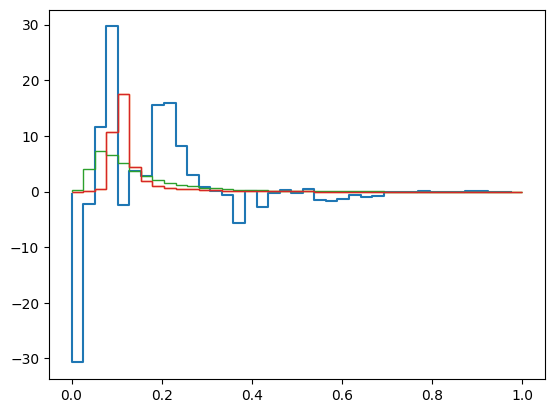

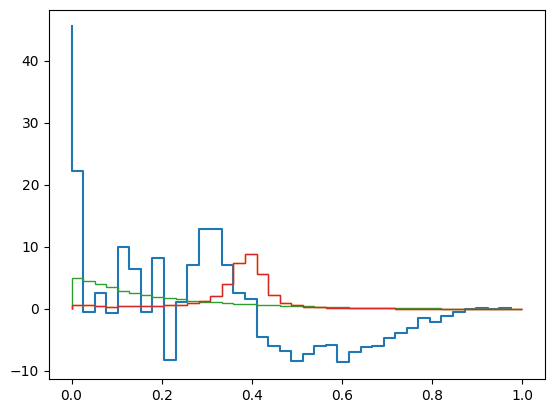

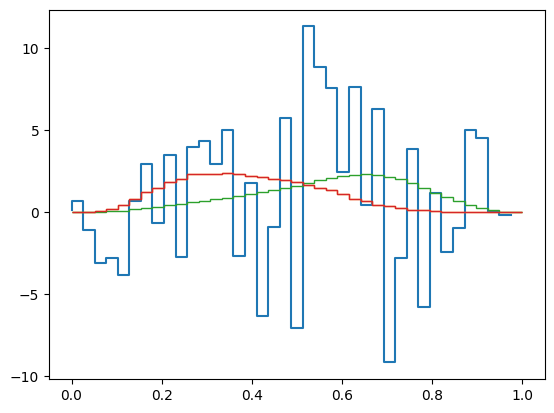

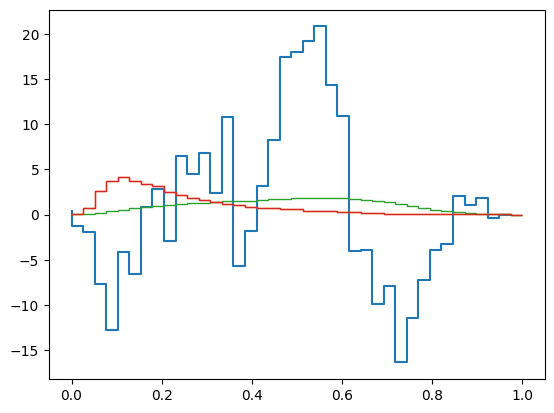

In [39]:
bins = np.linspace(0.0,1.0,40)

for i in range(1,5,1):
    hist_back,_ = np.histogram(samples_background_actual[:,i],bins=bins,density=True)
    hist_data,_ = np.histogram(samples_actual_anode[:,i],bins=bins,density=True)

    hist_sig = (hist_data - hist_back*(1-true_w))/true_w

    plt.step(bins[:-1],hist_sig,label='signal')
    plt.hist(true_signal[:,i],bins=bins,label='true signal',histtype='step',density=True)
    plt.hist(true_background[:,i],bins=bins,label='true background',histtype='step',density=True)
    plt.hist(true_signal[:,i],bins=bins,label='true signal',histtype='step',density=True)
   # plt.show()


   # plt.hist(samples_background_actual[:,i],bins=bins,label='background',histtype='step',density=True)
   # plt.hist(samples_actual[:,i],bins=bins,label='signal',histtype='step',density=True)
    plt.show()

In [20]:
#plt.hist(samples_actual[:,1], bins=60, density=True, histtype='step', label='ANODE')
#plt.show()
_data, _ , _, _ = resample_split('./data/lhc_co', n_sig = 1000, resample_seed = 1,resample = True)

background = np.load(f'{data_dir}/extrabkg_train_val.npy')

data = np.concatenate([_data,background],axis=0)


choosing random 1000 signal events for mock_data from 70000 events
sigma=2.1156509566250077
true w: 0.006036579872060546


In [9]:
from sklearn.preprocessing import StandardScaler

_x_test = np.load(f'{data_dir}/x_test.npy')
x_test_S = preprocess_params_transform(x_test, pre_parameters_CR)
#x_test_S[:,0]-=3.5
#scaler = StandardScaler()
#scaler.fit(data[:,0].reshape(-1,1))
#mass_transformed = scaler.transform(data[:,0].reshape(-1,1))
#data[:,0] = mass_transformed[:,0]
#mass_transformed_test = scaler.transform(x_test_S[:,0].reshape(-1,1))
#x_test_S[:,0] = mass_transformed_test[:,0]
x_test_tensor = torch.tensor(x_test_S).float()

In [ ]:
data_pre = preprocess_params_transform(data, pre_parameters_CR)
data_pre_tensor = torch.tensor(data_pre).float()

data_ = inverse_transform(data_pre_tensor, pre_parameters_CR).detach().numpy()

NameError: name 'data' is not defined

In [13]:
x_test_ = inverse_transform(x_test_tensor,pre_parameters_CR).detach().numpy()

In [10]:
x_test = np.load(f'{data_dir}/x_test.npy')
label = x_test[:,-1]

In [11]:
wandb_group = 'nflows_lhc_co_nsig_scan'

In [1]:
wandb_group_BDT = "BDT"
wandb_project_BDT = "IAD_weighted_50_1000"
wandb_job_type_BDT = "sample"

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [16]:
data.shape

(388715, 5)

# Samples vs method

(20, 122076)
0.1871471786902934
1069


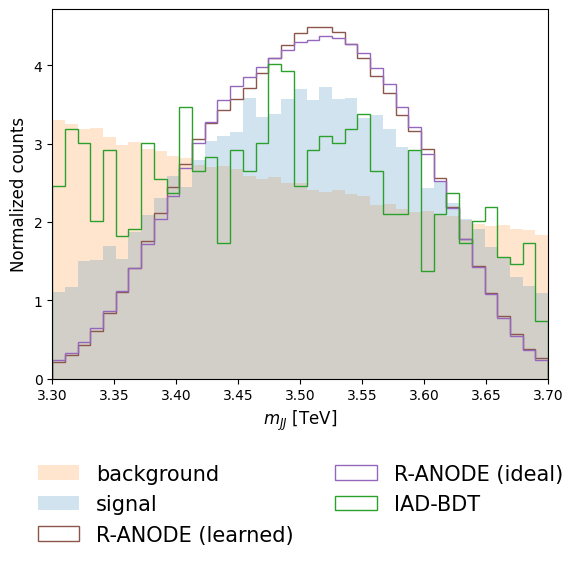

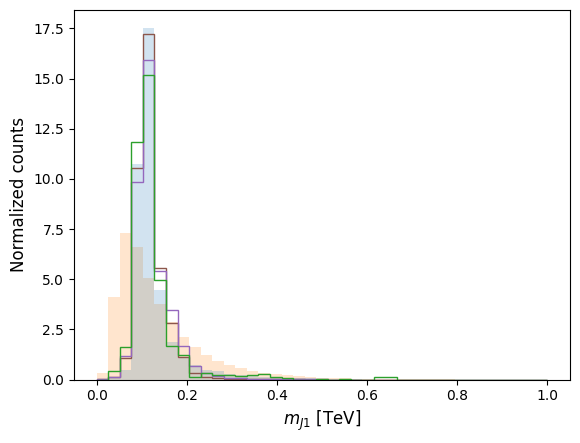

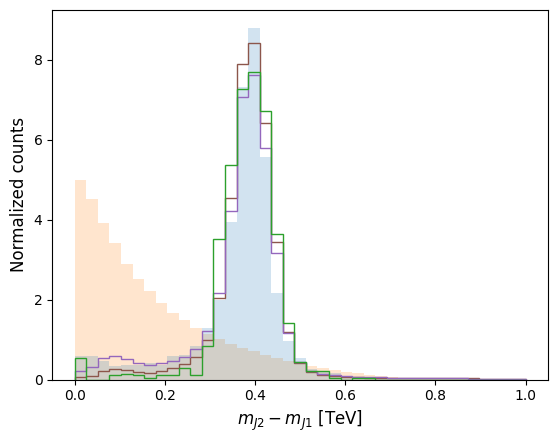

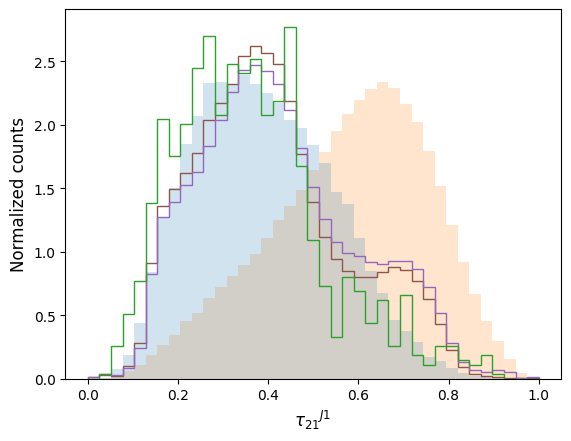

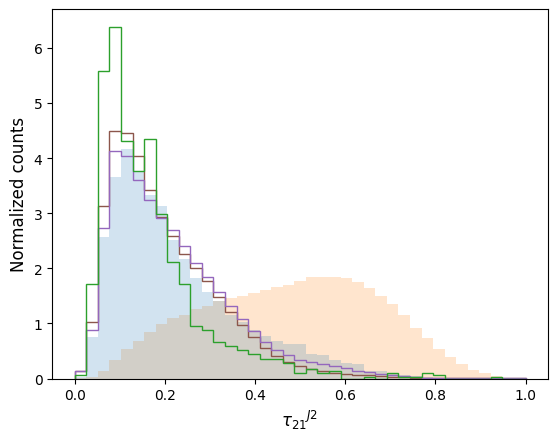

In [30]:
import pickle
wandb_group_BDT = "BDT"
wandb_project_BDT = "IAD_weighted_50_1000"
wandb_job_type_BDT = "sample"

#wandb_group = 'nflows_lhc_co_nsig_scan'
wandb_group_learned = 'nflows_lhco'
wandb_job_type_learned = 'joint_random_1000'
wandb_try_learned = 'try_0_'

wandb_group_ideal = 'nflows_lhc_co_nsig_scan'
wandb_job_type_ideal = 'ra_mass_joint_un_clip_1000'
wandb_try_ideal = 'try_0_'

wandb_group_no_signal = 'nflows_lhco'
wandb_job_type_no_signal = 'no_signal_fit'
wandb_try_no_signal = 'try_0_'

for i in range(10):
    if i==0:
        ypred = []
        for j in range(20):
            with open(f'./results/{wandb_group_BDT}/{wandb_project_BDT}/{wandb_job_type_BDT}_{i}/clf_{j}.pkl','rb') as f:
                model = pickle.load(f)
            ypred.append(model.predict_proba(x_train_S[:,1:-1])[:,1])
        
        ypred = np.array(ypred)
        print(ypred.shape)
        ypred = np.mean(ypred,axis=0)

        #ypred = np.concatenate(ypred,axis=0)


        #ypred = np.load(f'results/{wandb_group_BDT}/{wandb_project_BDT}/{wandb_job_type_BDT}_{i}/ypred.npy')
        R = ypred/(1-ypred)
        print(1-np.min(R))

        x_test_cut = x_train[R>1.1]

        print(np.sum(R>1.1))
       # plt.hist(ypred,bins=40,label='signal',histtype='step',density=True)
       # plt.show()

samples_r_anode_learned = []
for i in range(20):
    path = f'./results/{wandb_group_learned}/{wandb_job_type_learned}/{wandb_try_learned}{i}/'
    samples = np.load(path + 'samples.npy')
    valloss = np.load(path + 'valloss.npy')

    lowest_epochs = np.argsort(valloss)[:10]
    w_array = []
    for epoch in lowest_epochs:
        w_ = np.load(f'{path}/w_{epoch}.npy')
        w_array.append(w_)
    w_array = np.array(w_array).flatten()
    w_median = np.median(w_array)

    if w_median < 10**(-2.7):
        continue

    samples_r_anode_learned.append(samples)

r_anode_learned_samples = np.concatenate(samples_r_anode_learned,axis=0)
for i in range(1,5,1):
    r_anode_learned_samples[:,i] -= 3.5

samples_r_anode_ideal = []

for i in range(20):
    path = f'./results/{wandb_group_ideal}/{wandb_job_type_ideal}/{wandb_try_ideal}{i}/'
    samples = np.load(path + 'samples.npy')
    valloss = np.load(path + 'valloss.npy')

    
    samples_r_anode_ideal.append(samples)

   # r_anode_hist = np.histogram(samples[:,0],bins=100,density=True)

    #samples_r_anode.append(samples)

r_anode_ideal_samples = np.concatenate(samples_r_anode_ideal,axis=0)

for i in range(1,5,1):
    r_anode_ideal_samples[:,i] -= 3.5

samples_r_anode_no_signal = []

for i in range(20):
    path = f'./results/{wandb_group_no_signal}/{wandb_job_type_no_signal}/{wandb_try_no_signal}{i}/'
    if not os.path.exists(path + 'samples.npy'):
        continue


    samples = np.load(path + 'samples.npy')
    valloss = np.load(path + 'valloss.npy')
    lowest_epochs = np.argsort(valloss)[:10]

    w_array = []
    for epoch in lowest_epochs:
        w_ = np.load(f'{path}/w_{epoch}.npy')
        w_array.append(w_)
    w_array = np.array(w_array).flatten()
    w_median = np.median(w_array)

    if w_median < 10**(-4.2):
        continue

    samples_r_anode_no_signal.append(samples)

r_anode_no_signal_samples = np.concatenate(samples_r_anode_no_signal,axis=0)

for i in range(1,5,1):
    r_anode_no_signal_samples[:,i] -= 3.5
    #w_values 
   # print(samples.shape)

bins = np.linspace(0.0,1.0,40)
bins_mass = np.linspace(3.3,3.7,40)

x_labels = [r'$m_{JJ}$ [TeV]',r'$m_{J1}$ [TeV]',r'$m_{J2} - m_{J1}$ [TeV]',
            r'${\tau_{21}}^{J1}}$ ',r'${\tau_{21}}^{J2}}$ ']

for i in range(5):
    if i==0:

        plt.hist(x_test[:,i][label==0],bins=bins_mass,label='background',histtype='stepfilled',density=True,alpha=0.2,color='C1')
        plt.hist(x_test[:,i][label==1],bins=bins_mass,label='signal',histtype='stepfilled',density=True,alpha=0.2,color='C0')
        plt.hist(r_anode_learned_samples[:,i],bins=bins_mass,label='R-ANODE (learned)',histtype='step',density=True,color='C5')
        plt.hist(r_anode_ideal_samples[:,i],bins=bins_mass,label='R-ANODE (ideal)',histtype='step',density=True,color='C4')
        plt.hist(x_test_cut[:,i],bins=bins_mass,label='IAD-BDT',histtype='step',density=True,color='C2')
      #  plt.hist(r_anode_no_signal_samples[:,i],bins=bins_mass,label='R-ANODE (no signal)',histtype='step',density=True,color='C3')
        plt.legend(frameon=False,fontsize=15, loc='lower center', 
    bbox_to_anchor=(0.5, -0.50),
    ncol=2)
        plt.xlabel(x_labels[i],fontsize=12)
        plt.ylabel('Normalized counts',fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.xlim(3.3,3.7)
        plt.savefig('./figures/mass_comparison.pdf',bbox_inches='tight')
        plt.show()
    else:
        plt.hist(x_test[:,i][label==0],bins=bins,label='background',histtype='stepfilled',density=True,alpha=0.2,color='C1')
        plt.hist(x_test[:,i][label==1],bins=bins,label='signal',histtype='stepfilled',density=True,alpha=0.2,color='C0')
        plt.hist(r_anode_learned_samples[:,i],bins=bins,label='R-ANODE (learned)',histtype='step',density=True,color='C5')
        plt.hist(r_anode_ideal_samples[:,i],bins=bins,label='R-ANODE (ideal)',histtype='step',density=True,color='C4')
        plt.hist(x_test_cut[:,i],bins=bins,label='IAD-BDT',histtype='step',density=True,color='C2')
       # plt.hist(r_anode_no_signal_samples[:,i],bins=bins,label='R-ANODE (no signal)',histtype='step',density=True,color='C3')
        plt.xlabel(x_labels[i],fontsize=12)
        plt.ylabel('Normalized counts',fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.savefig(f'./figures/feature_{i}_comparison.pdf',bbox_inches='tight')
       # plt.legend(frameon=False, fontsize=10,loc = 'upper right', bbox_to_anchor=(1.4, 1))
        plt.show()
 
   # assert len(ypred) == len(x_test_S)




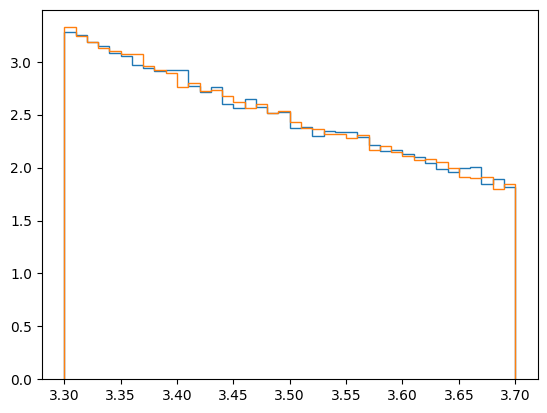

In [25]:
import numpy as np
extra_background = np.load(f'data/lhc_co/extrabkg_train_val.npy')
mass_true = np.load('data/lhc_co/true_mass.npy')
true_labels = np.load('data/lhc_co/true_labels.npy')

plt.hist(mass_true[true_labels==0],bins=40,label='background',histtype='step',density=True)
plt.hist(extra_background[:,0],bins=40,label='signal',histtype='step',density=True)
plt.show()

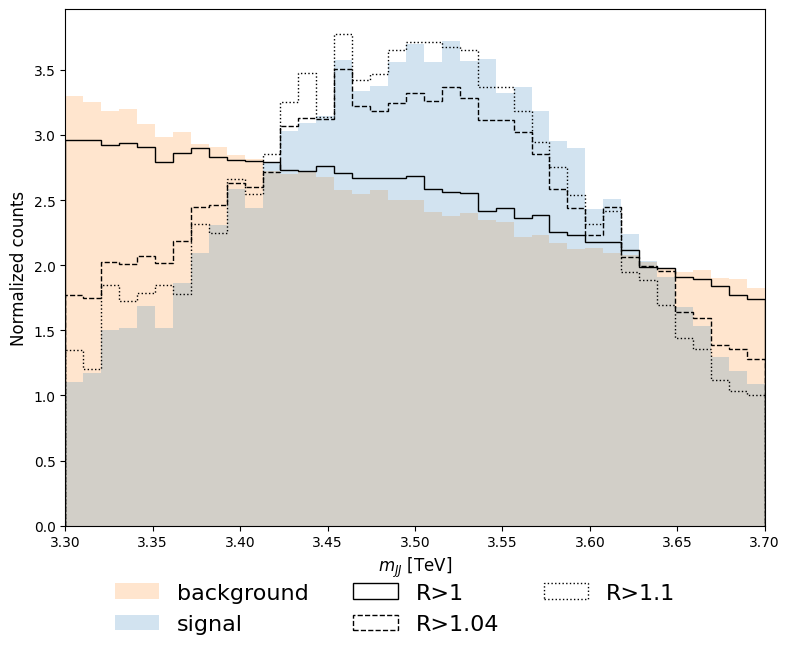

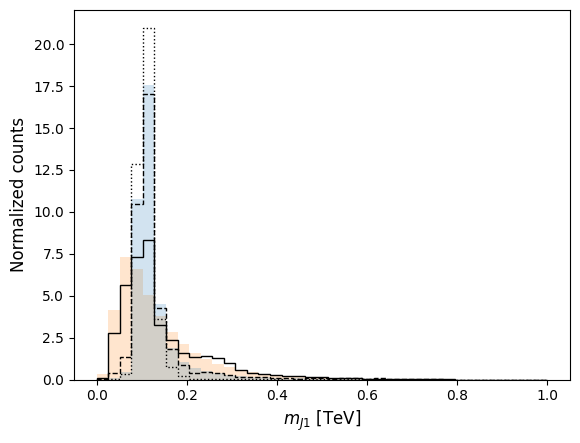

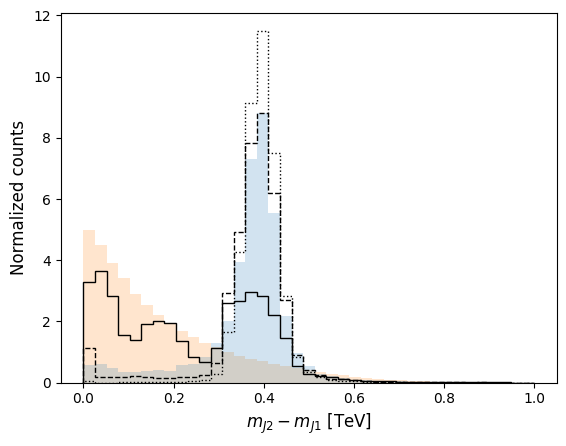

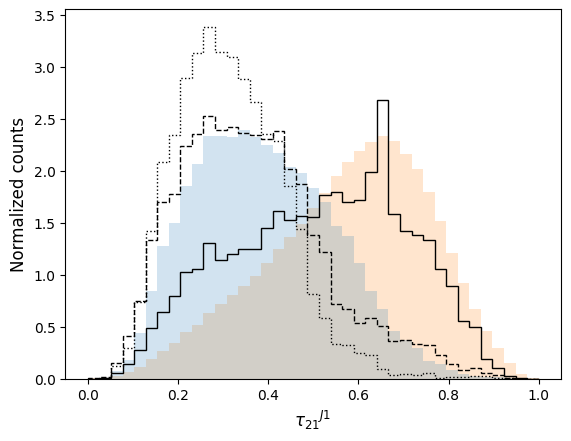

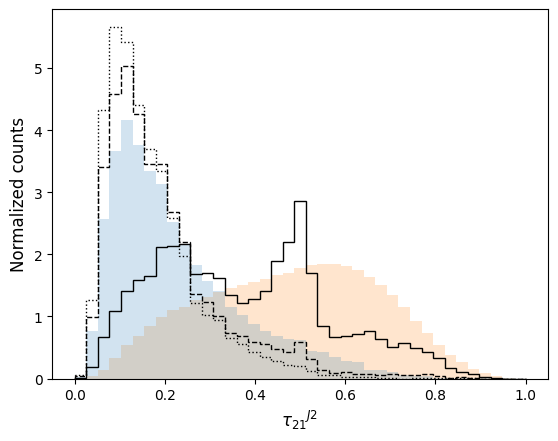

In [117]:
import pickle
wandb_group_BDT = "BDT"
wandb_project_BDT = "IAD_weighted_50_1000"
wandb_job_type_BDT = "sample"

bins = np.linspace(0.0,1.0,40)
bins_mass = np.linspace(3.3,3.7,40)

x_labels = [r'$m_{JJ}$ [TeV]',r'$m_{J1}$ [TeV]',r'$m_{J2} - m_{J1}$ [TeV]',
            r'${\tau_{21}}^{J1}}$ ',r'${\tau_{21}}^{J2}}$ ']

cuts = [1,1.04,1.1]
linestyles = ['solid','dashed','dotted']

for feature in range(5):
    if feature==0:
        fig = plt.figure(figsize=(8,6))

    for k,cut in enumerate(cuts):
        for i in range(10):
            if i==0:
                ypred = np.load(f'results/{wandb_group_BDT}/{wandb_project_BDT}/{wandb_job_type_BDT}_{i}/ypred.npy')
                R = ypred/(1-ypred)
                x_test_cut = x_test_[R>cut]
        # plt.hist(ypred,bins=40,label='signal',histtype='step',density=True)
        # plt.show()



        if feature==0:

            if cut==1:
                plt.hist(x_test[:,feature][label==0],bins=bins_mass,label='background',histtype='stepfilled',density=True,alpha=0.2,color='C1')
                plt.hist(x_test[:,feature][label==1],bins=bins_mass,label='signal',histtype='stepfilled',density=True,alpha=0.2,color='C0')
           # plt.hist(r_anode_learned_samples[:,i],bins=bins_mass,label='R-ANODE (learned)',histtype='step',density=True,color='C5')
          #  plt.hist(r_anode_ideal_samples[:,i],bins=bins_mass,label='R-ANODE (ideal)',histtype='step',density=True,color='C4')
            plt.hist(x_test_cut[:,feature],bins=bins_mass,label=f'R>{cut}',histtype='step',density=True,color='black',linestyle=linestyles[k])
        #  plt.hist(r_anode_no_signal_samples[:,i],bins=bins_mass,label='R-ANODE (no signal)',histtype='step',density=True,color='C3')
            
            plt.xlabel(x_labels[feature],fontsize=12)
            plt.ylabel('Normalized counts',fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.xlim(3.3,3.7)
            #if cut==1:
            
         #   plt.show()
        else:
            if cut==1:
                plt.hist(x_test[:,feature][label==0],bins=bins,label='background',histtype='stepfilled',density=True,alpha=0.2,color='C1')
                plt.hist(x_test[:,feature][label==1],bins=bins,label='signal',histtype='stepfilled',density=True,alpha=0.2,color='C0')
        #    plt.hist(r_anode_learned_samples[:,i],bins=bins,label='R-ANODE (learned)',histtype='step',density=True,color='C5')
         #   plt.hist(r_anode_ideal_samples[:,i],bins=bins,label='R-ANODE (ideal)',histtype='step',density=True,color='C4')
            plt.hist(x_test_cut[:,feature],bins=bins,label='IAD-BDT',histtype='step',density=True,color='black',linestyle=linestyles[k])
        # plt.hist(r_anode_no_signal_samples[:,i],bins=bins,label='R-ANODE (no signal)',histtype='step',density=True,color='C3')
            plt.xlabel(x_labels[feature],fontsize=12)
            plt.ylabel('Normalized counts',fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.savefig(f'./figures/feature_{feature}_comparison_IAD.pdf',bbox_inches='tight')
        # plt.legend(frameon=False, fontsize=10,loc = 'upper right', bbox_to_anchor=(1.4, 1))
         #   plt.show()
    #if feature ==0:
    if feature==0:
        fig.legend(frameon=False,fontsize=16, loc='lower center', 
            bbox_to_anchor=(0.5, -0.1),
            ncol=3)
        plt.tight_layout()
            #plt.tight_layout(rect=[0.0, 0.03, 1, 1])
        plt.savefig('./figures/mass_comparison_IAD.pdf',bbox_inches='tight')
        
    plt.show()
 
   # assert len(ypred) == len(x_test_S)




# Samples vs Nsig

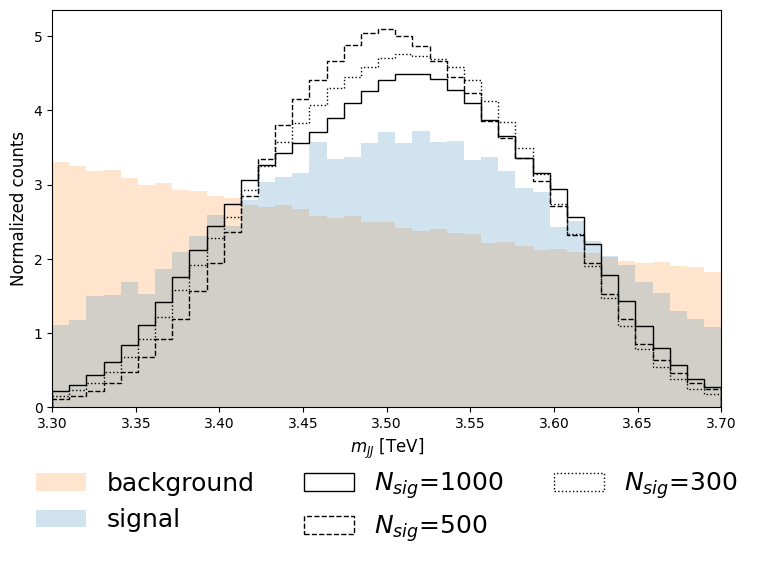

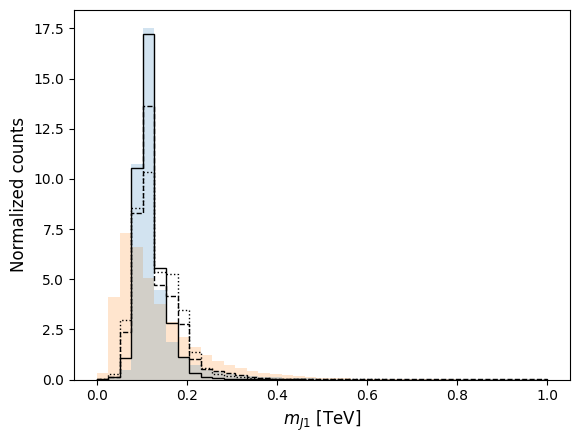

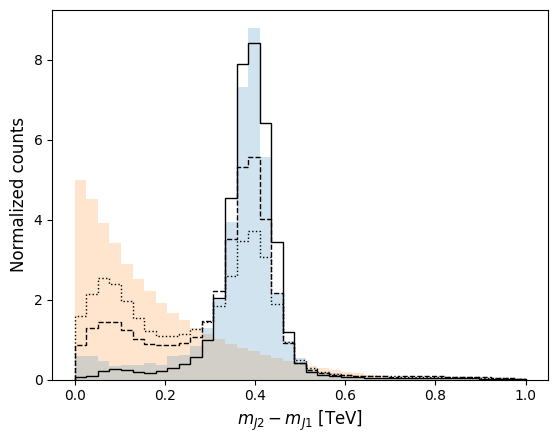

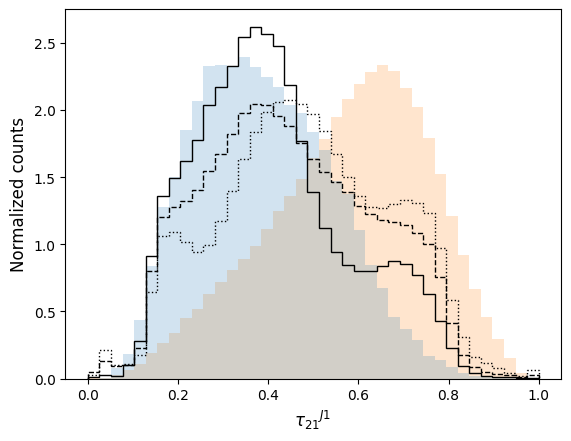

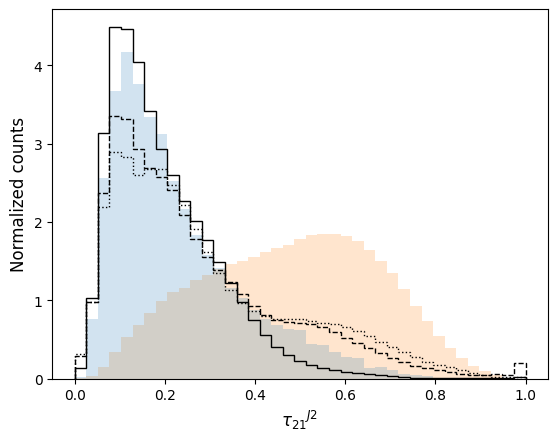

In [118]:
import pickle



bins = np.linspace(0.0,1.0,40)
bins_mass = np.linspace(3.3,3.7,40)

x_labels = [r'$m_{JJ}$ [TeV]',r'$m_{J1}$ [TeV]',r'$m_{J2} - m_{J1}$ [TeV]',
            r'${\tau_{21}}^{J1}}$ ',r'${\tau_{21}}^{J2}}$ ']

Nsig = [1000,500,300]
linestyles = ['solid','dashed','dotted']

for feature in range(5):
    if feature==0:
        fig = plt.figure(figsize=(8,6))
    for k,nsig in enumerate(Nsig):
        wandb_group_learned = 'nflows_lhco'
        wandb_job_type_learned = f'joint_random_{nsig}'
        wandb_try_learned = 'try_0_'

        wandb_group_ideal = 'nflows_lhc_co_nsig_scan'
        wandb_job_type_ideal = f'ra_mass_joint_un_clip_{nsig}'
        wandb_try_ideal = 'try_0_'

        samples_r_anode_learned = []
        for i in range(20):
            path = f'./results/{wandb_group_learned}/{wandb_job_type_learned}/{wandb_try_learned}{i}/'
            samples = np.load(path + 'samples.npy')
            valloss = np.load(path + 'valloss.npy')

            lowest_epochs = np.argsort(valloss)[:10]
            w_array = []
            for epoch in lowest_epochs:
                w_ = np.load(f'{path}/w_{epoch}.npy')
                w_array.append(w_)
            w_array = np.array(w_array).flatten()
            w_median = np.median(w_array)

            if nsig==1000:
                if w_median < 10**(-2.7):
                    continue
            else:
                if w_median < 10**(-4.0):
                    continue

            samples_r_anode_learned.append(samples)

        r_anode_learned_samples = np.concatenate(samples_r_anode_learned,axis=0)
        for i in range(1,5,1):
            r_anode_learned_samples[:,i] -= 3.5

        samples_r_anode_ideal = []

        for i in range(20):
            path = f'./results/{wandb_group_ideal}/{wandb_job_type_ideal}/{wandb_try_ideal}{i}/'
            samples = np.load(path + 'samples.npy')
            valloss = np.load(path + 'valloss.npy')

            
            samples_r_anode_ideal.append(samples)

        # r_anode_hist = np.histogram(samples[:,0],bins=100,density=True)

            #samples_r_anode.append(samples)

        r_anode_ideal_samples = np.concatenate(samples_r_anode_ideal,axis=0)

        for i in range(1,5,1):
            r_anode_ideal_samples[:,i] -= 3.5

        # plt.hist(ypred,bins=40,label='signal',histtype='step',density=True)
        # plt.show()



        if feature==0:
            if nsig==1000:
                plt.hist(x_test[:,feature][label==0],bins=bins_mass,label='background',histtype='stepfilled',density=True,alpha=0.2,color='C1')
                plt.hist(x_test[:,feature][label==1],bins=bins_mass,label='signal',histtype='stepfilled',density=True,alpha=0.2,color='C0')
           # plt.hist(r_anode_learned_samples[:,i],bins=bins_mass,label='R-ANODE (learned)',histtype='step',density=True,color='C5')
         #   plt.hist(r_anode_ideal_samples[:,feature],bins=bins_mass,label=r'$N_{sig}$'+f'={nsig}',histtype='step',density=True,
          #           color='black',linestyle=linestyles[k])
            plt.hist(r_anode_learned_samples[:,feature],bins=bins_mass,label=r'$N_{sig}$'+f'={nsig}',histtype='step',density=True,
                     color='black',linestyle=linestyles[k])
          #  plt.hist(x_test_cut[:,feature],bins=bins_mass,label=rf'$N_{sig}={nsig}$',histtype='step',density=True,color='black',linestyle=linestyles[k])
        #  plt.hist(r_anode_no_signal_samples[:,i],bins=bins_mass,label='R-ANODE (no signal)',histtype='step',density=True,color='C3')
            
            plt.xlabel(x_labels[feature],fontsize=12)
            plt.ylabel('Normalized counts',fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.xlim(3.3,3.7)
           # plt.savefig('./figures/mass_comparison_nsig_ideal.pdf',bbox_inches='tight')
         #   plt.show()
        else:
            if nsig==1000:
                plt.hist(x_test[:,feature][label==0],bins=bins,label='background',histtype='stepfilled',density=True,alpha=0.2,color='C1')
                plt.hist(x_test[:,feature][label==1],bins=bins,label='signal',histtype='stepfilled',density=True,alpha=0.2,color='C0')
        #    plt.hist(r_anode_learned_samples[:,i],bins=bins,label='R-ANODE (learned)',histtype='step',density=True,color='C5')
          #  plt.hist(r_anode_ideal_samples[:,feature],bins=bins,label='R-ANODE (ideal)',histtype='step',density=True,
           #          color='black',linestyle=linestyles[k])
            plt.hist(r_anode_learned_samples[:,feature],bins=bins,label=r'$N_{sig}$'+f'={nsig}',histtype='step',density=True,
                     color='black',linestyle=linestyles[k])
         #   plt.hist(x_test_cut[:,feature],bins=bins,label='IAD-BDT',histtype='step',density=True,color='black',linestyle=linestyles[k])
        # plt.hist(r_anode_no_signal_samples[:,i],bins=bins,label='R-ANODE (no signal)',histtype='step',density=True,color='C3')
            plt.xlabel(x_labels[feature],fontsize=12)
            plt.ylabel('Normalized counts',fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.savefig(f'./figures/feature_{feature}_comparison_nsig_learned.pdf',bbox_inches='tight')
        # plt.legend(frameon=False, fontsize=10,loc = 'upper right', bbox_to_anchor=(1.4, 1))
         #   plt.show()
    if feature ==0:
        plt.legend(frameon=False,fontsize=18, loc='lower center', 
            bbox_to_anchor=(0.5, -0.40),
            ncol=3)
        plt.tight_layout()
        plt.savefig('./figures/mass_comparison_nsig_learned.pdf',bbox_inches='tight')
    plt.show()
 
   # assert len(ypred) == len(x_test_S)




# Samples vs working points w

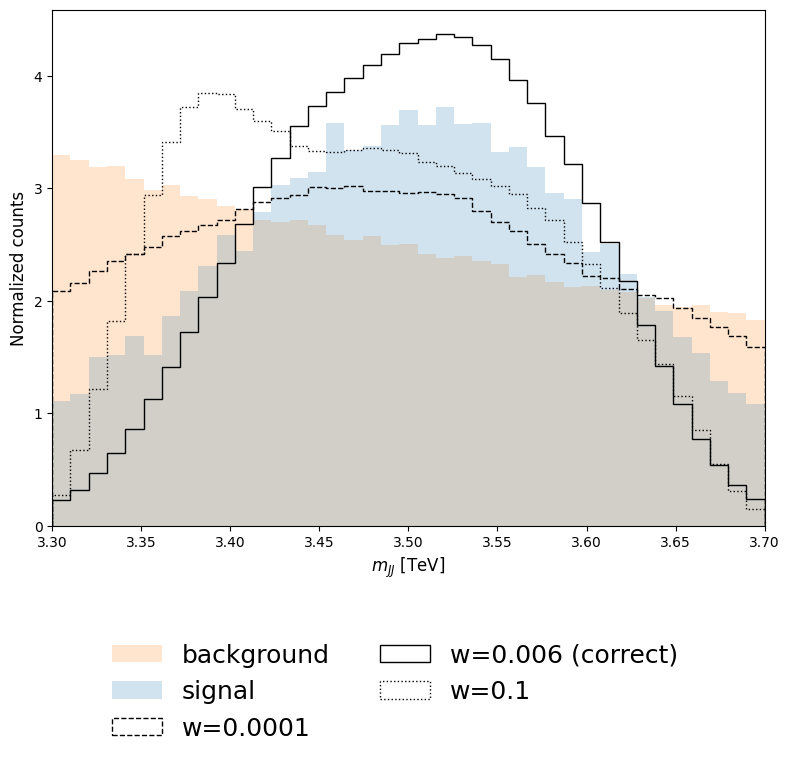

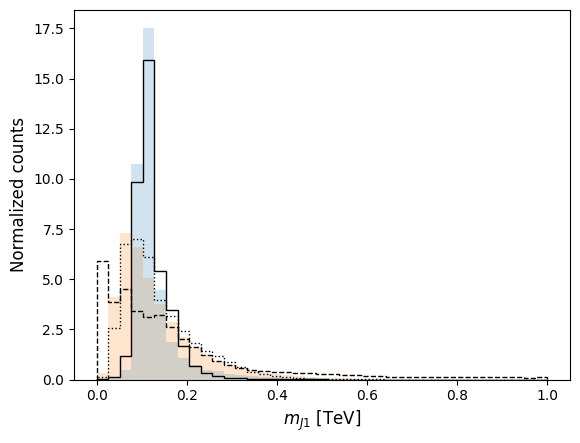

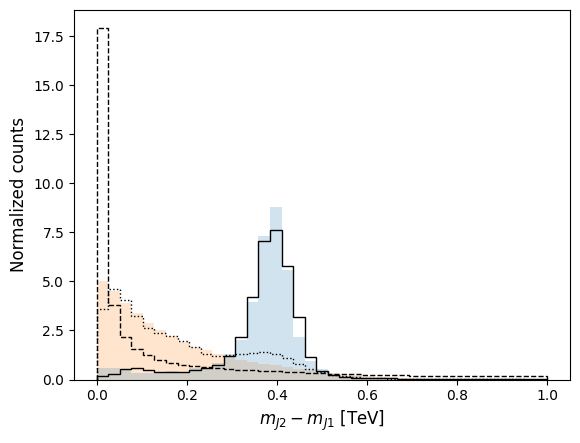

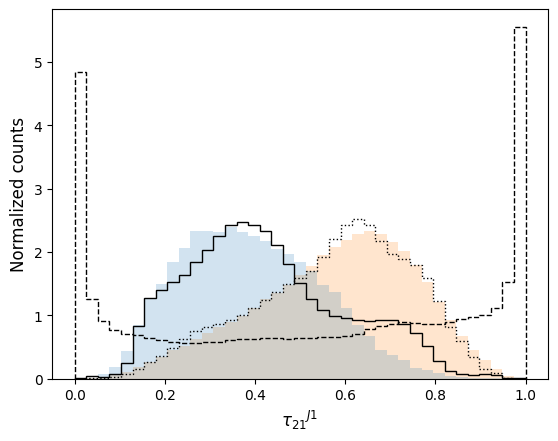

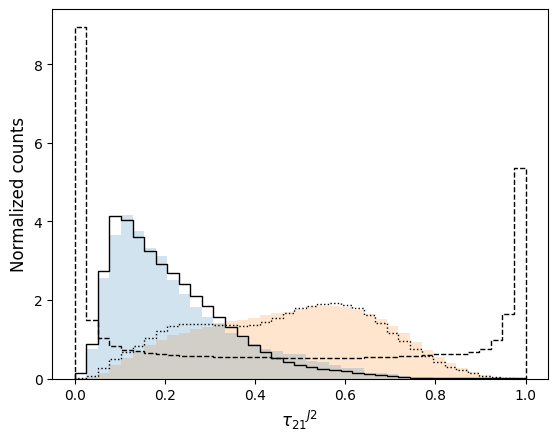

In [38]:
import pickle



bins = np.linspace(0.0,1.0,40)
bins_mass = np.linspace(3.3,3.7,40)
#w_ = [0.0001,0.001,0.006,0.01,0.1]

w_ = [0.0001,0.006,0.1]

true_w_ = 0.006

x_labels = [r'$m_{JJ}$ [TeV]',r'$m_{J1}$ [TeV]',r'$m_{J2} - m_{J1}$ [TeV]',
            r'${\tau_{21}}^{J1}}$ ',r'${\tau_{21}}^{J2}}$ ']

nsig=1000
linestyles = ['dashed','solid','dotted','dashdot',(0, (1, 10))]

samples_wscan = {}


for feature in range(5):
    if feature==0:
        fig = plt.figure(figsize=(8,6))
    for k,w in enumerate(w_):

        if w!=0.006:
            wandb_group_wscan = "nflows_lhc_co_w_scan"
            wandb_project_wscan = f"ra_mass_joint_{nsig}"
            wandb_project_wscan = f'{wandb_project_wscan}_{w}'
            wandb_job_type_wscan = "try_0_"
        else:
            wandb_group_wscan = "nflows_lhc_co_nsig_scan"
            wandb_project_wscan = f"ra_mass_joint_un_clip_{nsig}"
            wandb_job_type_wscan = "try_0_"

 

        samples_r_anode_ideal = []

        for i in range(20):
            path = f'./results/{wandb_group_wscan}/{wandb_project_wscan}/{wandb_job_type_wscan}{i}/'
            samples = np.load(path + 'samples.npy')
            valloss = np.load(path + 'valloss.npy')

            
            samples_r_anode_ideal.append(samples)

        # r_anode_hist = np.histogram(samples[:,0],bins=100,density=True)

            #samples_r_anode.append(samples)

        r_anode_ideal_samples = np.concatenate(samples_r_anode_ideal,axis=0)

        for i in range(1,5,1):
            r_anode_ideal_samples[:,i] -= 3.5

        # plt.hist(ypred,bins=40,label='signal',histtype='step',density=True)
        # plt.show()

        if feature==0:
            samples_wscan[w] = r_anode_ideal_samples




        if feature==0:
            if w==0.0001:
                plt.hist(x_test[:,feature][label==0],bins=bins_mass,label='background',histtype='stepfilled',density=True,alpha=0.2,color='C1')
                plt.hist(x_test[:,feature][label==1],bins=bins_mass,label='signal',histtype='stepfilled',density=True,alpha=0.2,color='C0')
           # plt.hist(r_anode_learned_samples[:,i],bins=bins_mass,label='R-ANODE (learned)',histtype='step',density=True,color='C5')
            if w==0.006:
                plt.hist(r_anode_ideal_samples[:,feature],bins=bins_mass,label=f'w={w} (correct)',histtype='step',density=True,
                     color='black',linestyle=linestyles[k])
            else:    
                plt.hist(r_anode_ideal_samples[:,feature],bins=bins_mass,label=f'w={w}',histtype='step',density=True,
                     color='black',linestyle=linestyles[k])
       #     plt.hist(r_anode_learned_samples[:,feature],bins=bins_mass,label=r'$w$'+f'={w}',histtype='step',density=True,
        #             color='black',linestyle=linestyles[k])
          #  plt.hist(x_test_cut[:,feature],bins=bins_mass,label=rf'$N_{sig}={nsig}$',histtype='step',density=True,color='black',linestyle=linestyles[k])
        #  plt.hist(r_anode_no_signal_samples[:,i],bins=bins_mass,label='R-ANODE (no signal)',histtype='step',density=True,color='C3')
            
            plt.xlabel(x_labels[feature],fontsize=12)
            plt.ylabel('Normalized counts',fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.xlim(3.3,3.7)
           # plt.savefig('./figures/mass_comparison_wscan.pdf',bbox_inches='tight')
         #   plt.show()
        else:
            if w==0.0001:
                plt.hist(x_test[:,feature][label==0],bins=bins,label='background',histtype='stepfilled',density=True,alpha=0.2,color='C1')
                plt.hist(x_test[:,feature][label==1],bins=bins,label='signal',histtype='stepfilled',density=True,alpha=0.2,color='C0')
        #    plt.hist(r_anode_learned_samples[:,i],bins=bins,label='R-ANODE (learned)',histtype='step',density=True,color='C5')
            plt.hist(r_anode_ideal_samples[:,feature],bins=bins,label='R-ANODE (ideal)',histtype='step',density=True,
                     color='black',linestyle=linestyles[k])
           # plt.hist(r_anode_learned_samples[:,feature],bins=bins,label=r'$w$'+f'={w}',histtype='step',density=True,
             #        color='black',linestyle=linestyles[k])
         #   plt.hist(x_test_cut[:,feature],bins=bins,label='IAD-BDT',histtype='step',density=True,color='black',linestyle=linestyles[k])
        # plt.hist(r_anode_no_signal_samples[:,i],bins=bins,label='R-ANODE (no signal)',histtype='step',density=True,color='C3')
            plt.xlabel(x_labels[feature],fontsize=12)
            plt.ylabel('Normalized counts',fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.savefig(f'./figures/feature_{feature}_comparison_wscan.pdf',bbox_inches='tight')
        # plt.legend(frameon=False, fontsize=10,loc = 'upper right', bbox_to_anchor=(1.4, 1))
         #   plt.show()
    if feature ==0:
        fig.legend(frameon=False,fontsize=18, loc='lower center', 
            bbox_to_anchor=(0.5, -0.28),
            ncol=2)
        plt.tight_layout()
        plt.savefig('./figures/mass_comparison_wscan.pdf',bbox_inches='tight')
    plt.show()

   # if feature==0:
     #   samples_wscan[feature].append(r_anode_ideal_samples)
   # samples_wscan[feature].append(r_anode_ideal_samples)

 
   # assert len(ypred) == len(x_test_S)




/tmp/ipykernel_56542/3981148741.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax4 = plt.subplot2grid((3,6), (1,1), colspan=2,rowspan=4)
/tmp/ipykernel_56542/3981148741.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax5 = plt.subplot2grid((3,6), (1,3), colspan=2,rowspan=4)


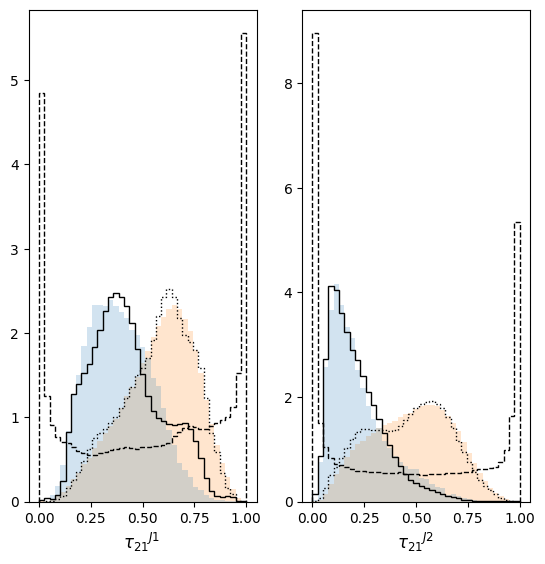

In [46]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((3,6),loc=(0,0), colspan=2,rowspan=4)
ax2 = plt.subplot2grid((3,6), (0,2), colspan=2,rowspan=4)
ax3 = plt.subplot2grid((3,6), (0,4), colspan=2,rowspan=4)
ax4 = plt.subplot2grid((3,6), (1,1), colspan=2,rowspan=4)
ax5 = plt.subplot2grid((3,6), (1,3), colspan=2,rowspan=4)

axes = [ax1,ax2,ax3,ax4,ax5]

for i,ax in enumerate(axes):
    
    #if i ==0:
    if i==0:
        bins = np.linspace(3.3,3.7,40)
    else:
        bins = np.linspace(0.0,1.0,40)
        
    ax.hist(x_test[:,i][label==0],bins=bins,label='background',histtype='stepfilled',density=True,alpha=0.2,color='C1')
    ax.hist(x_test[:,i][label==1],bins=bins,label='signal',histtype='stepfilled',density=True,alpha=0.2,color='C0')
    ax.hist(samples_wscan[0.0001][:,i],bins=bins,label='w=0.0001',histtype='step',density=True,color='black',linestyle='dashed')
    ax.hist(samples_wscan[0.006][:,i],bins=bins,label='w=0.006',histtype='step',density=True,color='black',linestyle='solid')
    ax.hist(samples_wscan[0.1][:,i],bins=bins,label='w=0.1',histtype='step',density=True,color='black',linestyle='dotted')
    ax.set_xlabel(x_labels[i],fontsize=12)
   # ax.set_ylabel('Normalized counts',fontsize=12)
    #ax.set_xticks(fontsize=10)
    #ax.set_yticks(fontsize=10)
  #  ax.legend(frameon=False,fontsize=10, loc='upper center', 
   # bbox_to_anchor=(0.5, -0.35),
   # ncol=3)





plt.subplots_adjust(hspace=0.3, wspace=0.5)




#plt.legend(frameon=False,fontsize=18, loc='upper center')